In [ ]:
!pip install -q gensim scikit-learn tensorflow

import json
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, f1_score

from gensim.models import Word2Vec

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


In [ ]:
from google.colab import files
uploaded = files.upload()

with open("Sarcasm_Headlines_Dataset.json", "r") as f:
    data = [json.loads(line) for line in f]
df = pd.DataFrame(data)
df = df[["headline", "is_sarcastic"]]


Saving sarcasm_classification_project.py to sarcasm_classification_project.py


In [ ]:
stop_words = set(ENGLISH_STOP_WORDS)

def preprocess(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

df["clean_headline"] = df["headline"].apply(preprocess)


In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df["clean_headline"])
y = df["is_sarcastic"]

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Naive Bayes": MultinomialNB()
}

f1_results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred))
    f1_results[name] = f1_score(y_test, y_pred)



--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      2996
           1       0.79      0.69      0.74      2346

    accuracy                           0.78      5342
   macro avg       0.78      0.77      0.78      5342
weighted avg       0.78      0.78      0.78      5342


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      2996
           1       0.76      0.71      0.73      2346

    accuracy                           0.77      5342
   macro avg       0.77      0.77      0.77      5342
weighted avg       0.77      0.77      0.77      5342


--- Naive Bayes ---
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      2996
           1       0.80      0.69      0.74      2346

    accuracy                           0.79      5342
   macro avg       0.79      0.78      0.78      5342
w

In [ ]:
svd = TruncatedSVD(n_components=300)
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

pca_model = LogisticRegression(max_iter=1000)
pca_model.fit(X_train_svd, y_train)
y_pred_svd = pca_model.predict(X_test_svd)

print("\n--- Logistic Regression (TF-IDF + SVD) ---")
print(classification_report(y_test, y_pred_svd))
f1_results["LogReg + SVD"] = f1_score(y_test, y_pred_svd)



--- Logistic Regression (TF-IDF + SVD) ---
              precision    recall  f1-score   support

           0       0.71      0.86      0.78      2996
           1       0.76      0.55      0.63      2346

    accuracy                           0.72      5342
   macro avg       0.73      0.70      0.71      5342
weighted avg       0.73      0.72      0.71      5342



In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["clean_headline"])
sequences = tokenizer.texts_to_sequences(df["clean_headline"])
word_index = tokenizer.word_index
max_len = 20
X_seq = pad_sequences(sequences, maxlen=max_len)
y_seq = df["is_sarcastic"].values

sentences = [s.split() for s in df["clean_headline"]]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]


In [ ]:
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=embedding_matrix.shape[0],
                         output_dim=100,
                         weights=[embedding_matrix],
                         input_length=max_len,
                         trainable=False))
lstm_model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(1, activation="sigmoid"))

lstm_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
lstm_model.fit(X_train_seq, y_train_seq, epochs=5, batch_size=128, validation_split=0.1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 45s 146ms/step - accuracy: 0.5677 - loss: 0.6805 - val_accuracy: 0.6088 - val_loss: 0.6538
Epoch 2/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 26s 49ms/step - accuracy: 0.6067 - loss: 0.6575 - val_accuracy: 0.6191 - val_loss: 0.6460
Epoch 3/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.6213 - loss: 0.6475 - val_accuracy: 0.6270 - val_loss: 0.6319
Epoch 4/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.6246 - loss: 0.6439 - val_accuracy: 0.6331 - val_loss: 0.6303
Epoch 5/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.6297 - loss: 0.6361 - val_accuracy: 0.6214 - val_loss: 0.6327


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

--- LSTM Model ---
F1 Score: 0.3673


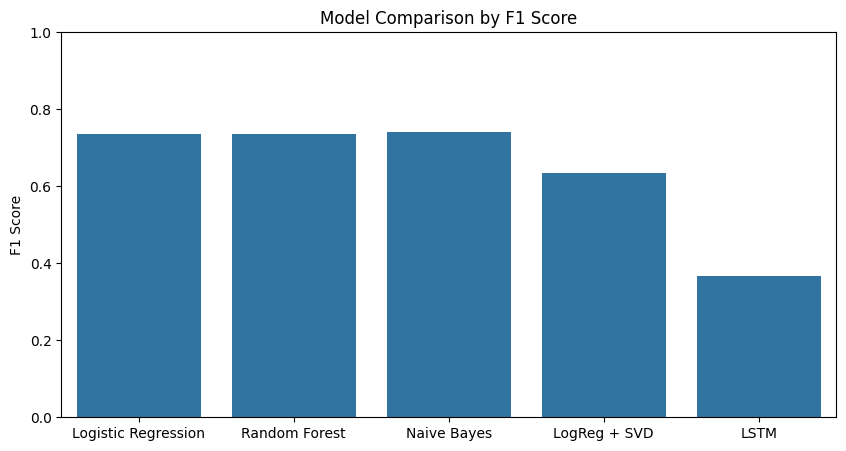

In [ ]:
lstm_preds = (lstm_model.predict(X_test_seq) > 0.5).astype("int32")
lstm_f1 = f1_score(y_test_seq, lstm_preds)
print(f"\n--- LSTM Model ---\nF1 Score: {lstm_f1:.4f}")
f1_results["LSTM"] = lstm_f1

# Визуализация сравнения
plt.figure(figsize=(10, 5))
sns.barplot(x=list(f1_results.keys()), y=list(f1_results.values()))
plt.ylabel("F1 Score")
plt.title("Model Comparison by F1 Score")
plt.ylim(0, 1)
plt.show()
